## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import scipy.stats as st
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

C:\PROGRA1\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Import Datasets

In [2]:
df = pd.read_csv('ab_data.csv')
country = pd.read_csv('countries.csv')

** Let's check out the first few rows **

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
## Number of Rows
df.shape[0]

294478

In [6]:
## Number of Unique User Ids
df.user_id.nunique()

290584

In [7]:
## Proportion of Converted Users
df.converted.sum()/ab.shape[0]

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [8]:
df[((df.group=='treatment') & (df.landing_page!='new_page'))].shape[0]

1965

In [9]:
df[((df.group!='treatment') & (df.landing_page=='new_page'))].shape[0]

1928

In [10]:
1965+1928

3893

Do any of the rows have missing values?

In [11]:
df.shape[0] - df.dropna().shape[0]

0

In [12]:
np.count_nonzero(df.isnull())

0

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. We will drop these rows 

In [6]:
drop_df = df[((df.group=='treatment') & (df.landing_page!='new_page')) | ((df.group!='treatment') & (df.landing_page=='new_page'))]

In [7]:
## Drop Rows 
indexes_to_keep = set(range(df.shape[0])) - set(drop_df.index)
df2 = df.take(list(indexes_to_keep))

In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

In [16]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


a. How many unique **user_id**s are in **df2**?

In [17]:
indiv = df2.groupby('user_id')
indiv.user_id.nunique().sum()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [143]:
indiv.count().sort_values('timestamp', ascending=False).head()

,timestamp,group,landing_page,converted
user_id,,,,
773192,2,2,2,2
630000,1,1,1,1
840701,1,1,1,1
840707,1,1,1,1
840706,1,1,1,1


c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
df2.drop(1899, inplace=True)

C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
## checking to see if drop worked
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [21]:
p_converted = df2.converted.sum()/df2.shape[0]
p_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
p_convert_control = df2[df2.group=='control'].converted.sum()/df2[df2.group=='control'].shape[0]
p_convert_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
p_convert_treatment = df2[df2.group=='treatment'].converted.sum()/df2[df2.group=='treatment'].shape[0]
p_convert_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [24]:
p_new = df2[df2.landing_page=='new_page'].shape[0]/df2.shape[0]
p_new

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

In [25]:
p_convert_treatment - p_convert_control

-0.0015782389853555567

- By just glancing at our sample proportions, it appears to be that the difference in proportions between the control and treatment groups is small(-0.0016). 
- In fact, based on this sample alone there were *fewer* conversions in the treatment group than control group.
- To conclude: there does not appear to be enough evidence to say that there is a significant difference between page conversion rates. That will depend on the standard error of the conversion rate differences

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


$$H_{0}: p_{old} >= p_{new}$$
$$H_{a}: p_{old} < p_{new}$$

This is a one-sided hypothesis test

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [26]:
null_p_new = df2.converted.mean()
null_p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [27]:
null_p_old = df2.converted.mean()
null_p_old

0.11959708724499628

c. What is $n_{new}$?

In [28]:
new = df2[df2.group=='treatment']
new.shape[0]

145310

d. What is $n_{old}$?

In [29]:
old = df2[df2.group=='control']
old.shape[0]

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [116]:
new_page_converted = np.random.choice([1,0], p=[null_p_new, 1-null_p_new], size=new.shape[0])

In [117]:
new_page_converted = np.asarray(new_page_converted, dtype=np.float32)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [118]:
old_page_converted = np.random.choice([1,0], p=[null_p_old, 1-null_p_old], size=new.shape[0])

In [119]:
old_page_converted = np.asarray(old_page_converted, dtype=np.float32)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [120]:
null_diff = new_page_converted.mean()-old_page_converted.mean()
null_diff

0.00053678453

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [123]:
alt_p_old = p_convert_control

In [122]:
alt_p_new = p_convert_treatment

In [126]:
p_diffs = []
for i in range(10000):
    #old_samp = np.random.choice(old.converted, size=old.converted.shape[0], replace=True)
    old_samp = np.random.choice([1,0], p=[alt_p_old, 1-alt_p_old], size=old.shape[0])
    #new_samp = np.random.choice(new.converted, size=new.converted.shape[0], replace=True)
    new_samp = np.random.choice([1,0], p=[alt_p_new, 1-alt_p_new], size=new.shape[0])
    p_old = old_samp.mean()
    p_new = new_samp.mean()
    p_diffs.append(p_new-p_old)   

In [127]:
p_diffs = np.asarray(p_diffs, dtype=np.float32)

In [128]:
p_diffs.mean()

-0.0015913155

In [129]:
p_diffs.std()

0.0011976885

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [130]:
null_dist = np.random.normal(0, p_diffs.std(), size=10000)

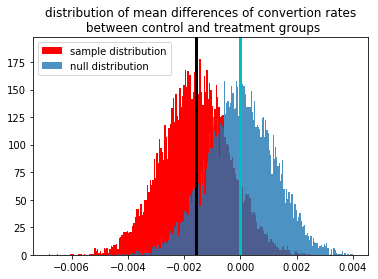

In [131]:
plt.hist(p_diffs, bins=200, color='r', label='sample distribution');
plt.hist(null_dist, bins=200, label='null distribution', alpha=0.8);
plt.axvline(x=0, color='c', linewidth=3); #### 0 mean vertical line
plt.axvline(x=p_diffs.mean(), color='k', linewidth=3); ### sample mean vertical line
plt.title('distribution of mean differences of convertion rates\n between control and treatment groups');
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [184]:
### proportion of sample distribution that is greater than 0
(p_diffs > 0).mean()

0.092299999999999993

In [185]:
### proportion of null datat that is greter than the mean of the sample distribution
p = 1-(p_diffs > 0).mean()
p

0.90769999999999995

In [150]:
### manually calculate z-score
z = p_diffs.mean()/p_diffs.std()

In [187]:
### probability of being larger than z
1-st.norm.cdf(z)

0.90801919031014644

In [186]:
### z-score for the critical value
st.norm.ppf(0.95)

1.6448536269514722

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- Only 9.2% of the mean differences were greater than 0, subtracting this value from 1 yields what is called a p-value. 
- p = 90.8%
    - 90.8% of values from the Null Distribution exceeded the Actual mean difference of -0.0016
- The p-value indicates the probability of incorrectly rejecting the Null Hypothesis when it is true (Type I error). It is a benchmark related to the number of standard deviations the mean of our Alternative distribution must be *distanced* from the mean of the Null distribution in order to make the assertion that there is a *true, significant* difference in population means.
    - The lower the p-value, the farther away from the mean of our Alternative distribution must differ from the mean of our null distribution in order to reject the Null Hypothesis.
    - The large p-value indicates that we should *not* reject the Null Hypothesis and assert that the Old Page is equivalent or better in converting page visitors than the New Page.
    - In order to reject the Null Hypothesis we would have needed the p_diffs mean to be at least 1.64 standard deviations greater than 0 (p-value <= 0.05) 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [138]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted,treatment,control,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1


In [140]:
import statsmodels.api as sm
## I'm using variables in part c,d 
convert_old = old.converted.sum()
convert_new = new.converted.sum()
n_old = old.shape[0]
n_new = new.shape[0]

In [141]:
## control conversions, test conversions, control users, test users
print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [180]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- The z-score in this case measures how many standard deviations the mean conversion rate difference lies from 0 in the null distribution.
    - A z-score(-1.3116) reinforces the fact that the mean difference in conversion rates lies 1.3116 standard deviatons *below*  the the Null mean of 0 
    - This means that on average the New Page actually has a *lower* conversion rate than the Old Page.
    - The p-value for this z-test is 1-Probability(z-score)
    - We would still not reject the Null Hypothesis in this case 
    - The z and p values generated from the stats_proportion function are extremely close to their respective values from parts j&k

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regresssion

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [55]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted,treatment,control,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1


In [8]:
### creating dummy variables for experimental group
df2[['treatment', 'control']] = pd.get_dummies(df['group'])

C:\PROGRA1\Anaconda3\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [9]:
### creating intercept column
df2['intercept'] = 1

C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
### subsetting the data I will use for regression model
df_train = df2.drop(['user_id', 'timestamp', 'group', 'landing_page', 'control'], axis=1, inplace=False)

In [11]:
## The baseline variable for the experimental group will be the control group
df_train.head()

,converted,treatment,intercept
0,0,1,1
1,0,1,1
2,0,0,1
3,0,0,1
4,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [12]:
lg = sm.Logit(df_train['converted'], df_train[['treatment', 'intercept']])
result = lg.fit()

NameError: name 'sm' is not defined

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [148]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Dec 2017   Pseudo R-squ.:               8.077e-06
Time:                        23:07:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0150      0.011      1.311      0.190      -0.007       0.037
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?



- p-value in this case would be that for the coefficient of the treatment variable, or 0.19
    - It is the probability of being greater than the absolute value of the z-score of the treatment coefficient
    - It is the p-value of the sample coefficient for a two-sided hypothesis test 

$$H_{0}: {\beta_1} = 0$$
$$H_{a}: {\beta_1} \neq 0$$
- The Null Hypothesis in Part II was one-sided while the one performed for the estimation of the parameters was a two-sided hypothesis test

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- Adding additional (independent) variables may be beneficial to our model because simply indicating whether a page was a control or test page is not sufficient to predict converison as indicated above.
    - Additional variables to consider may include: 
        - time of day 
        - time of year for a promotion 
        - if there was exposure to other media existing in either online ads or on the radio
        - where in the world the web page was being viewed from
- If additional terms are added and they are colinear (high Variance Inflation Factor) we increase the likelyhood of getting near 0 valued coefficients according to their hypothesis tests and perhaps falsely rejecting them as legitimate parameters in our model

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [194]:
### right-joining the data frame with the country data frame
df_join = pd.merge(df2, country, how='right')

In [195]:
### checking to make sure all of the data was captured
df_join.shape[0]

290584

In [196]:
# are there any missing values from our join? 
np.count_nonzero(df.isnull())

0

In [197]:
### create dummy bariables
df_join[['US', 'CA', 'UK']] = pd.get_dummies(df_join['country'])

In [170]:
### The baseline variable for the country will be the UK
### The baseline variable for the experimental group will be the control group

In [198]:
### subsetting data to be used in model
df_train2 = df_join[['converted', 'treatment', 'US', 'CA', 'intercept']]

In [199]:
lg = sm.Logit(df_train2['converted'], df_train2[['treatment', 'US', 'CA', 'intercept']])
result = lg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Dec 2017   Pseudo R-squ.:               2.323e-05
Time:                        08:02:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0149      0.011      1.307      0.191      -0.007       0.037
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
CA             0.0099      0.013      0.743      0.457      -0.016       0.036
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
==============================================================================
"""

- Adding the country does *not* improve the performance of the model, the p-values for all coefficients (except the intercept) are not significant enough to use

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [200]:
df_train2['interaction'] = df_train2['treatment']*(df_train2['US']+df_train2['CA'])

C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [201]:
df_train2.head(1)

,converted,treatment,US,CA,intercept,interaction
0,0,1,0,0,1,0


In [202]:
lg = sm.Logit(df_train2['converted'], df_train2[['treatment', 'US', 'CA', 'intercept', 'interaction']])
result = lg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Mon, 18 Dec 2017   Pseudo R-squ.:               2.589e-05
Time:                        08:03:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2390
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
treatment       0.0206      0.014      1.505      0.132      -0.006       0.047
US             -0.0314      0.030     -1.059      0.289      -0.089       0.027
CA              0.0193      0.018      1.057      0.290      -0.017       0.055
intercept      -2.0070      0.010   -207.045      0.000      -2.026      -1.988
interaction    -0.0188      0.025     -0.752      0.452      -0.068       0.030
===============================================================================
"""

- Adding an interaction term does *not* improve the model performance, the p-values for all coefficients (except the intercept) are well above 0.05
- It is safe to conclude, given the data thus far, that the new landing page with the country of origin of the user and the interaction term taken into consideration does not significantly alter the probability of converting the customer positively or negatively
- In fact, the $\beta_{0}$ estimation indicates that the probability of conversion is approximately 13.5% (our null hypothesis from Part II was 11.96%)

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by continuing on to the next module in the program.